In [2]:
import kagglehub
import numpy as np
import csv

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

In [3]:
# Download latest version of dataset
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/justiniverson/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1


In [4]:
# Load and preprocess dataset
dataset_path = "/kaggle/input/sms-spam-collection-dataset/spam.csv"
dataset_path = path + "/spam.csv"

with open(dataset_path, 'r', encoding='latin-1') as f:
    reader = csv.reader(f)
    rows = list(reader)

if rows[0][0].lower() == "v1":
    rows = rows[1:]

data = np.array([[r[0], r[1]] for r in rows], dtype=object)
labels = data[:, 0]
messages = data[:, 1]

labels = np.where(labels == "spam", 1, 0)
print(labels.shape)
print(messages.shape)

(5572,)
(5572,)


In [5]:
# Split and vectorize dataset
X_train, X_test, y_train, y_test = train_test_split(messages, labels, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

print("Vectorized shape:", X_train_vec.shape)

Vectorized shape: (4457, 7735)


In [6]:
input_dim = X_train_vec.shape[1] # number of features

def create_model(units1=64, units2=32):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(units1, activation="relu"),
        layers.Dense(units2, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = KerasClassifier(
    model=create_model,
    epochs=3,
    batch_size=32,
    verbose=0
)

param_grid = {
    "model__units1": [8, 16, 32, 64, 128],
    "model__units2": [8, 16, 32, 64, 128]
}

grid = GridSearchCV(model, param_grid, cv=3)
grid_result = grid.fit(X_train_vec, y_train)

print("Best params:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)

Best params: {'model__units1': 32, 'model__units2': 16}
Best score: 0.9874354431106337


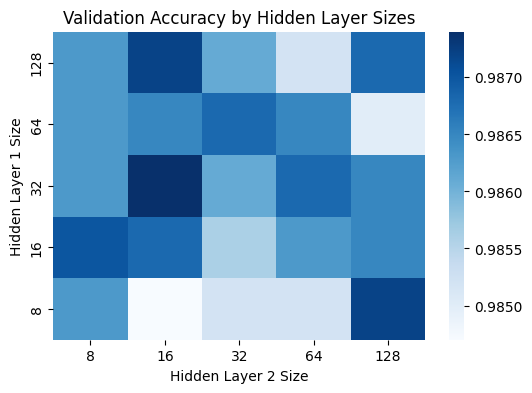

In [7]:
results = []

params_list = grid_result.cv_results_["params"]
scores = grid_result.cv_results_["mean_test_score"]

for params, score in zip(params_list, scores):
    results.append({
        "units1": params["model__units1"],
        "units2": params["model__units2"],
        "Accuracy": round(score, 4)
    })

# Create DataFrame
df_results = pd.DataFrame(results)

# Create pivot table (visual grid)
pivot_table = df_results.pivot(index="units1", columns="units2", values="Accuracy")

plt.figure(figsize=(6, 4))
sns.heatmap(
    pivot_table,
    annot=False,
    cmap="Blues",
    fmt=".3f"
)

plt.title("Validation Accuracy by Hidden Layer Sizes")
plt.xlabel("Hidden Layer 2 Size")
plt.ylabel("Hidden Layer 1 Size")
plt.gca().invert_yaxis()
# plt.savefig("heatmap_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
history = model.fit(
    X_train_vec, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32
)

probs = model.predict(X_test_vec).flatten()
preds = (probs >= 0.5).astype(int)

acc = accuracy_score(y_test, preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, preds, average="binary", zero_division=0
)

print("Test accuracy:", acc)
print("Test precision:", prec)
print("Test recall:", rec)
print("Test F1:", f1)

Test accuracy: 0.979372197309417
Test precision: 1.0
Test recall: 0.8466666666666667
Test F1: 0.9169675090252708


In [9]:
# checking three misclassified inputs / some other stuff

misclassified_idx = np.where(y_test != preds)[0]
print(f"Total number of test data texts model classified: {len(y_test)}")
print(f"Number of texts model got wrong: {len(misclassified_idx)}\n")

cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)
print("True Positive:", tp, '\n')

for i in misclassified_idx[:3]:
    print(X_test[i])
    is_spam = y_test[i] == 1
    print("Model got this incorrect. This is actually", "SPAM." if is_spam else "NOT SPAM.", "\n")

print(f"Spam guess freq: {round(len(np.where(preds == 1)[0]) / len(preds), 3)}")
print(f"Actual spam freq: {round(len(np.where(y_test == 1)[0]) / len(y_test), 3)}")

Total number of test data texts model classified: 1115
Number of texts model got wrong: 23

True Negative: 965
False Positive: 0
False Negative: 23
True Positive: 127 

Hi I'm sue. I am 20 years old and work as a lapdancer. I love sex. Text me live - I'm i my bedroom now. text SUE to 89555. By TextOperator G2 1DA 150ppmsg 18+
Model got this incorrect. This is actually SPAM. 

Loans for any purpose even if you have Bad Credit! Tenants Welcome. Call NoWorriesLoans.com on 08717111821
Model got this incorrect. This is actually SPAM. 

ringtoneking 84484
Model got this incorrect. This is actually SPAM. 

Spam guess freq: 0.114
Actual spam freq: 0.135
